# LAB -- Projectile Motion

**Please write your name in this box**

*We encourage you to work together, and seek whatever help you need in completing this lab.  Please list all people who you worked with or received help from*

*We encourage you to use any online resources that you find useful. Please list any URL's that you consulted*

*We encourage you to use AI resources if you find them useful.  If you made use of AI, please list the platform and the prompts which you made use of*

## Load in Packages, and set up logger

In [1]:
using Plots,Logging,ProgressMeter

Set up Logger

In [2]:
default_logger=global_logger()
debug_logger=ConsoleLogger(stderr, Logging.Debug); # set up logger

### Example of putting debug statements into a function

In [3]:
function addnumbers(a,b)
    @debug "addnumbers called with arguments" a b
    result=a+b
    @debug "calculated result as" result
    return result
end

addnumbers (generic function with 1 method)

In [4]:
# example of sending debug messages to standard error
with_logger(debug_logger) do # Enable the debug logger locally
    addnumbers(2,3)
end

┌ Debug: addnumbers called with arguments
│   a = 2
│   b = 3
└ @ Main In[3]:2
┌ Debug: calculated result as
│   result = 5
└ @ Main In[3]:4


5

Here is a new trick.  We can enable the debug logger globally with

In [5]:
global_logger(debug_logger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [6]:
addnumbers(2,3)

┌ Debug: addnumbers called with arguments
│   a = 2
│   b = 3
└ @ Main In[3]:2
┌ Debug: calculated result as
│   result = 5
└ @ Main In[3]:4


5

In [7]:
# Change back to the default logger
# -- which does not print debug statements
global_logger(default_logger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Debug, Logging.default_metafmt, true, 0, Dict{Any, Int64}())

In [8]:
addnumbers(2,3)

5

Thus we can turn on and off the debug logger with the commands

    global_logger(debug_logger)
    global_logger(default_logger)

### Group Debugging

Having trouble with some code?  I will circulate to help you.  Post the problem code to *Ed Discussions* (linked through the Canvas site), and we can debug it as a class. This is a great way to work on debugging skills.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:blue; color:white;" >
## Goal
</h2>

Your goal in this lab is to write a function which will calculate the trajectory of a projectile, including drag forces. You will input the initial velocity (as a vector), and it will return a function which gives $x$ and $y$ as a function of time, until the object hits the ground.  You will then explore the distance that the projectile travels as a function of the launch angle.

In lecture we wrote a simple fixed time-step Runge Kutta integrator, and also the `DifferentialEquations.jl` package, which implements more sophisticated algorithms.  For this projectile problem, we need to stop the integrator when the projectile hits the ground.  A-priori we do not know when this occurs.  There are [mechanisms](https://docs.sciml.ai/DiffEqDocs/stable/features/callback_functions/)  to do this with `DifferentialEquations.jl`, but it will be much easier to simply use our hand-built integrator.  The effort needed to learn how to use the package is more than the effort to just code it ourself.

## Physics

A projectile obeys the second order differential equations:
\begin{align}
m\frac{d^2 {\bf \vec{r}}}{dt^2}&=
-m g {\bf\hat{y}}+{\bf\vec{F}}_d
\end{align}
where ${\bf\vec{F}}_d$ is the drag force.
In our approach to solving differential equations numerically, we need to write this as a set of coupled first order differential equations
\begin{align}
\frac{d {\bf \vec{r}}}{dt}&= {\bf \vec{v}}\\
\frac{d {\bf \vec{v}}}{dt}&=
-g {\bf\hat{y}}+\frac{{\bf\vec{F}}_d}{m}
\end{align}
We create a length 4 vector whose components are $(x,y,vx,vy)$, and update this vector at each time step.

In a typical introductory physics course one introduces two different models for ${\bf\vec{F}}_d$:
\begin{align}
{\bf\vec{F}}_d^{(1)}&=-\alpha {\bf\vec{v}}\\
{\bf\vec{F}}_d^{(2)}&=-\beta |v|{\bf\vec{v}}.
\end{align}
Linear drag is typically a good model for laminar flow in highly viscous media.  Quadratic drag is typically a good model for turbulent flow.  Typical projectiles are better modelled by quadratic drag.  An ansatz which interpolates between these is
$$
{\bf\vec{F}}_d=-\gamma |v|^{\delta-1}{\bf\vec{v}}.
$$
The case $\delta=1$ corresponds to linear drag, and $\delta=2$ to quadratic drag.

As usual, we need to *adimensionalize* these equations.  There two natural options for doing this for the current problem:
1. We could use an arbitrary fixed set of units.  For example, we know that most projectile problems that we deal with will involve meters, seconds, meters/seconds.  So we could simply use numerical values in SI units
2. We could extract the scale from the inital conditions.  For example, if the initial speed is $v_0$, then a good characteristic time is $\tau=v_0/g$, and a good characteristic distance is $v_0^2/g$.

Here we will use the first approach.  We will call our function with $v0x,v0y,g,\gamma,\delta$, and assume the user has chosen the numerical values so that they are all dimensionally consistent.   

Caution:  If you use an arbitrary fixed set of units, be careful that your parameters do not end up either extremely large or extremely small.  Don't use meters for an atomic problem, or seconds for a cosmology problem.  Otherwise you are vulnerable to round-off error, and a host of other challenges.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Question 1
</h2>

Assuming that one inputs $v_0$ in units of m/s, and $g$ in units of m/s$^2$.  What are the units for $\gamma$?

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 1
</h2>

For this activity we will try a workflow where we simultaneously have a notebook open and a text file open.  We will develop code in the notebook -- and then when it works copy it into the file.

If you are not already using JupyterLab, click the `Open in...` button, which appears on the upper right of the notebook.  Select `JupyterLab`.

Make sure that you are not in `Simple` mode.  There is a slider on the bottom left of the JupyterLab interface.  Make sure it is slid to the left.

Click on `File`, `New`, `Julia File`

Drag the title of the new file to the right.  You should be able to make it so that the notebook and the file are shown side-by-side

Right-click on the title and select "rename".  Call it  "Pendulumlab.jl"

Here is the code we developed in lecture for integrating a differential equation.  Copy the code to your ".jl" file, and save it

In [9]:
"""
    evolve(x0,dxdt,timerange,stepper)

integrates a differential equation.

`x0` - the dynamical variables at the original time -- can be a number, a vector, a tuple, etc
`dxdt(x,t)` -- a function of `x` and `t`,  Should return an object of the same type as `x0`
            -- evaluates to the right hand side of the differential equation
`timerange` -- a tuple `(ti,tf,dt)` listing the initial and final time, as well as the timestep
`stepper`

    stepper(x,dxdt,t,deltat))

gives you the value of `x` at the next timestep
"""
function evolve(x0,dxdt,timerange,stepper=rk4step)
    ti,tf,dt=timerange
    numsteps=floor(Int,(tf-ti)/dt)
    x=collect(x0) #converts to a vector
                  #works fine without "collect" if you restrict input to vectors
    result=Array{typeof(x)}(undef,numsteps+1)
    result[1]=x
    t=ti
    for j in 1:numsteps
        x=stepper(x=x,dxdt=dxdt,t=t,deltat=dt)
        result[j+1]=x
        t+=dt
    end
    return result
end

evolve(;x0,dxdt,timerange,stepper=eulerstep)=evolve(x0,dxdt,timerange,stepper)

function rk4step(x,dxdt,t,deltat)
    k1=dxdt(x,t)
    k2=dxdt(x+k1*(deltat/2),t+deltat/2)
    k3=dxdt(x+k2*(deltat/2),t+deltat/2)
    k4=dxdt(x+k3*deltat,t+deltat)
    return x+(k1+2*k2+2*k3+k4)*(deltat/6)
end

rk4step(;x,dxdt,t,deltat)=rk2step(x,dxdt,t,deltat)

function pendulum_dxdt(x,t)
    (theta,v)=x
    return [v,-sin(theta)]
end

pendulum_dxdt (generic function with 1 method)

You can load that file in with

In [10]:
include("Pendulumlab.jl")

distance (generic function with 2 methods)

Repeat that line whenever you change the file and want to update the state of your interactive session.  My recommendation is that you just put functions and object definitions in your file, and do the actual execution in your notebook

Test the routines in that file, by running the following lines

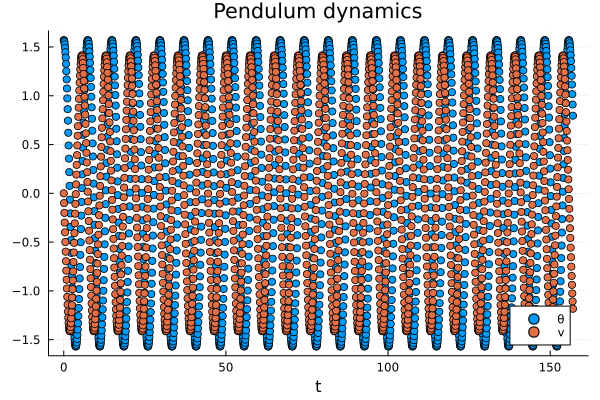

In [11]:
rk4ev=evolve([pi/2,0.],pendulum_dxdt,(0,50*pi,0.1),rk4step)
rk4times=0:0.1:50*pi
Plots.scatter(rk4times,first.(rk4ev),label="θ",xlabel="t",title="Pendulum dynamics")
Plots.scatter!(rk4times,last.(rk4ev),label="v",xlabel="t")

Finally, you will find it useful to open a "contextual help window".  Under the "Help" tab, select "Show Contextual Help".  Move the window so that it is on the same tab bar as `Pendulumlab.jl`.  You can then move between them as desired.

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 2
</h2>

One thing we need to decide is how we are going to pass parameters like $\gamma$ and $\delta$ to our stepper.  There are a number of strategies for this.  One way is to make the `projectile_dxdt` function a more sophisticated object, that knows about the parameters

### Example of Making a Function-like object

Here is an example of making a function which contains a parameter

In [12]:
# define struct that stores a spring constant
struct spring_force
    k # spring constant
end

# lets a spring-force object act like a function
function (V::spring_force)(x)
    return (1/2)*V.k*x^2
end

#Note, in this case, one could have used the simpler notation
#   (V::spring_force)(x)=(1/2)*V.k*x^2

In [13]:
V1=spring_force(5)
V2=spring_force(10)

spring_force(10)

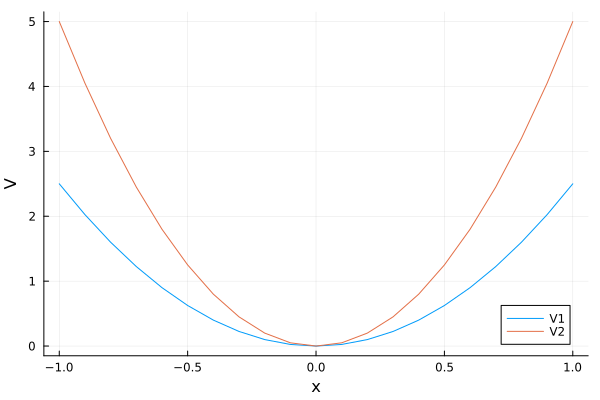

In [14]:
xvals=-1:0.1:1
V1vals=[V1(x) for x in xvals]
V2vals=[V2(x) for x in xvals]
plot(xvals,V1vals,label="V1",xlabel="x",ylabel="V")
plot!(xvals,V2vals,label="V2")

I always like to add a "keyword constructor" to my objects, so I can call them with keywords

In [15]:
# Provide a keyword constructor
spring_force(;k)=spring_force(k)

spring_force

In [16]:
V1b=spring_force(k=5)

spring_force(5)

In [17]:
V1b(2)

10.0

I also like to provide a keyword version of calling the function

In [18]:
(V::spring_force)(;x)=(V)(x)

In [19]:
V1(x=1)

2.5

### Example of making a **function generator**

An alternative approach is to make a function which generates a function

In [20]:
function spring_force2(k)
    potential(x)=(1/2)*k*x^2 #declare function
    potential(;x)=potential(x) #enable call by keyword
    return potential
end

spring_force2 (generic function with 1 method)

In [21]:
V3=spring_force2(2.)

(::var"#potential#17"{Float64}) (generic function with 2 methods)

In [22]:
V3(1)

1.0

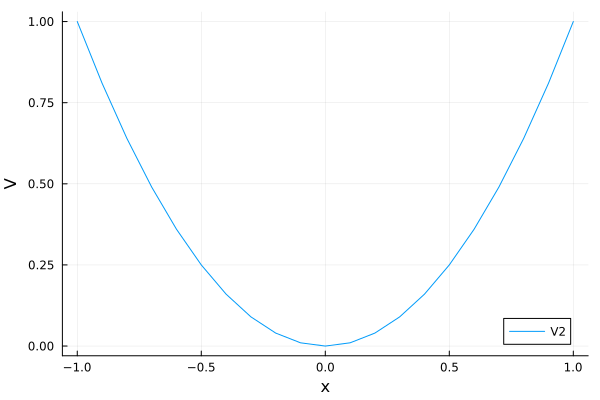

In [23]:
V3vals=[V3(x) for x in xvals]
plot(xvals,V3vals,label="V2",xlabel="x",ylabel="V")

### Activity

**Use one of these two strategies (or another that you prefer) to make a `projectile_dxdt` object/function.**  

When instantiating or generating the object you will need to pass along $m$, $\gamma$, $\delta$, and $g$.  (Those three parameters play the role of $k$ in the spring potential example.)  

For example, you might write

    dxdt1=projectile_dxdt(m=1,gamma=0,delta=1,g=9.8)

Once instantiated, your object/function should be callable by two parameters, `xv` and `t`.  Here `xv` should be a length 4 vector, with elements $x,y,v_x,v_y$.  It will ignore `t` -- which we include in case we later want to apply time-dependent forces.

For example, you could call it with

    dxdt1([1,2,0.5,-0.1],0.3)

It should return the right hand side of our differential equation

\begin{align}
\frac{d {\bf \vec{r}}}{dt}&= {\bf \vec{v}}\\
\frac{d {\bf \vec{v}}}{dt}&=
-g {\bf\hat{y}}-\frac{\gamma}{m} |v|^{\delta-1}{\bf\vec{v}}
\end{align}

**Include a docstring which describes how your object is used.**  I loke to write my docstrings first -- that way I have a clear goal. 

**Test your object by using different values of the parameters**

For example, if you set $\gamma=0$ it is easy to see if you are getting the gravity part right.  Then set $g=0$, and see if you are getting the drag part right.  Use a bunch of different velocity directions:  start with the cardinal directions, then do the case of 45 degrees.

When your function is working, copy the code into the `Pendulumlab.jl` file.  Don't erase it from the notebook, and don't erase your testing.  The idea is that the notebook is a "Lab Notebook" documenting how you validated your functions.  At some later time you can look up what you did.  The `Pendulumlab.jl` is your "final program" which you can use in future work.

If you edit `Pendulumlab.jl` -- you can load in the edits to your interactive notebook session with `include("Pendulumlab.jl")`

In [24]:
#My Solution

"""
    projectile_dxdt(m,gamma,delta,g)

creates a function-like object:

    dxdt1= projectile_dxdt(1,0,1,9.8)

and

    dxdt1(xv,t)

is the right hand side of our pendulum differential equation.
Here `xv=(x,y,vx,vy)`  and `dxdt1` returns `(dxdt,dydt,dvxdt,dvydx(`
"""
struct projectile_dxdt
    m
    gamma
    delta
    g
end

projectile_dxdt(;m,gamma,delta,g)=projectile_dxdt(m,gamma,delta,g)

function (dxdt::projectile_dxdt)(xv,t)
    x,y,vx,vy=xv
    m=dxdt.m
    gamma=dxdt.gamma
    delta=dxdt.delta
    g=dxdt.g
    dragprefactor=(gamma/m)*(vx^2+vy^2)^((delta-1)/2)
    dvx=-dragprefactor*vx
    dvy=-g-dragprefactor*vy
    return [vx,vy,dvx,dvy]
end

(dxdt::projectile_dxdt)(;xv,t)=dxdt(xv,t)

In [25]:
dxdt1=projectile_dxdt(m=1,gamma=0,delta=1,g=9.8)

projectile_dxdt(1, 0, 1, 9.8)

In [26]:
dxdt1([0,0,0,0],0)

4-element Vector{Float64}:
  0.0
  0.0
 -0.0
 -9.8

In [27]:
dxdt1([0,0,1,2],0)

4-element Vector{Float64}:
  1.0
  2.0
 -0.0
 -9.8

In [28]:
dxdt2=projectile_dxdt(m=1,gamma=1,delta=1,g=0)

projectile_dxdt(1, 1, 1, 0)

In [29]:
dxdt2([0,0,1,2],0)

4-element Vector{Float64}:
  1.0
  2.0
 -1.0
 -2.0

In [30]:
dxdt3=projectile_dxdt(m=1,gamma=2,delta=1,g=0)

projectile_dxdt(1, 2, 1, 0)

In [31]:
dxdt3([0,0,1,2],0)

4-element Vector{Float64}:
  1.0
  2.0
 -2.0
 -4.0

In [32]:
dxdt4=projectile_dxdt(m=1,gamma=1,delta=2,g=0)

projectile_dxdt(1, 1, 2, 0)

In [33]:
dxdt4([0,0,1,0],0)

4-element Vector{Float64}:
  1.0
  0.0
 -1.0
  0.0

In [34]:
dxdt4([0,0,1,1],0)

4-element Vector{Float64}:
  1.0
  1.0
 -1.4142135623730951
 -1.4142135623730951

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 3
</h2>

We are now ready to write a new version of our `evolve` function, which instead of running our stepper a fixed number of times, runs it until the projectile arrives at a position with $y<0$.

Go scroll though your `pendulum.jl` file so that you can see the code we used for `evolve`.  We will call our new function `projectile_trajectory` -- as it will return the trajectory of our projectile

The function will need to be called with:
    `xv0` -- the initial (x,y,vx,vy)
    `dxdt` -- the function or function-like object which gives the derivatives
    `dt` -- the timestep

We don't need to tell it which stepper to use -- we can just hard code it for `rk4`.    

Note: We do not know how many timesteps we will be taking.  Thus the command `result=Array{typeof(x)}(undef,numsteps+1)` doesn't make any sense.  Instead we will need to create an array of a single element, say with `result=[xv0]`, and later grow the trajectory list with `push!(result,xv)`.  Here is an example:

In [35]:
v1=[1.,2.]

2-element Vector{Float64}:
 1.0
 2.0

In [36]:
push!(v1,3.)
v1

3-element Vector{Float64}:
 1.0
 2.0
 3.0

Another thing we will need to deal with is the way we do the looping.  Look up the documentation for `while`.

Finally we need to worry about how we will return the answer.  The simplest is just returning a `tuple`  of the form `(times,xv_list)` -- where `times` is a vector of all the times, and `xv_list` is a vector of length-4 vectors (ie. a $N\times4$ matrix), which gives `xv` at each time.

**Write the `projectile_trajectory` function**.  Debugging/validating it is non-trivial.  Start by getting a working version, then go through the validating steps described below.  You may want to turn on the global debug logger, and add appropriate `@log` commands.

Don't forget to write a docstring

In [37]:
# my solution
"""
    projectile_trajectory(xv0,dxdt,dt)
takes an initial vector `xv0=[x,y,vx,vy]`, 
a function `dxdt` which gives the derivitive,
and a timestep `dt`, and uses Runge Kutta
to integrate the differential equation until `y` becomes negative

    dxdt(xv,t)
returns the vector [dx/dt,dy/dt,dvx/dt,dvy/dt]
"""
function projectile_trajectory(xv0,dxdt,dt)
    xv=collect(xv0)
    trajectory=[xv]
    times=[zero(dt)]
    t=dt
    while xv[2]>=0
        xv=rk4step(xv,dxdt,t,dt)
        push!(trajectory,xv)
        push!(times,t)
        t+=dt
    end
    return (times,trajectory)
end

projectile_trajectory

### Validation

Here are some test cases to look at.  Verify that your function acts correctly in each case.  Make plots or look at particular elements to convince yourself it is working.  For plots, do not forget to label your axes.

### Dropping off a cliff

Start with initial conditions: $(x,y,vx,vy)=(0.,1.,0.,0.)$, with parameters $m=1.,g=1.,\gamma=0.,\delta=1.$.  This corresponds to the elementary problem of dropping a rock off a cliff, neglecting drag.  

Verify that the $v_y(t)$ and $y(t)$ functions match what you expect.  

Double $g$, and make sure it changes as expected.  

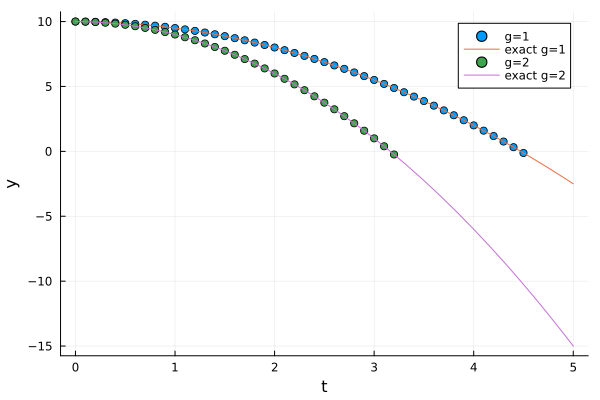

In [38]:
#my solution

tcliff1,xvcliff1=projectile_trajectory([0.,10.,0.,0.],
    projectile_dxdt(m=1,g=1,gamma=0,delta=1),0.1)
scatter(tcliff1,[xv[2] for xv in xvcliff1],label="g=1",
    xlabel="t",ylabel="y")
plot!(y->10-y^2/2,0,5,label="exact g=1")

tcliff2,xvcliff2=projectile_trajectory([0.,10.,0.,0.],
    projectile_dxdt(m=1,g=2,gamma=0,delta=1),0.1)
scatter!(tcliff2,[xv[2] for xv in xvcliff2],label="g=2",
    xlabel="t",ylabel="y")
plot!(y->10-2*y^2/2,0,5,label="exact g=2")

### Frictionless Projectile

Now do the case $(x,y,vx,vy)=(0.,0.,1.,1.)$, with parameters $m=1.,g=1.,\gamma=0.,\delta=1.$.  Plot $y(t)$ vs $x(t)$.  If that works, double the initial $v_x$, and see if it makes the right change.  Now double the initial $v_y$. 

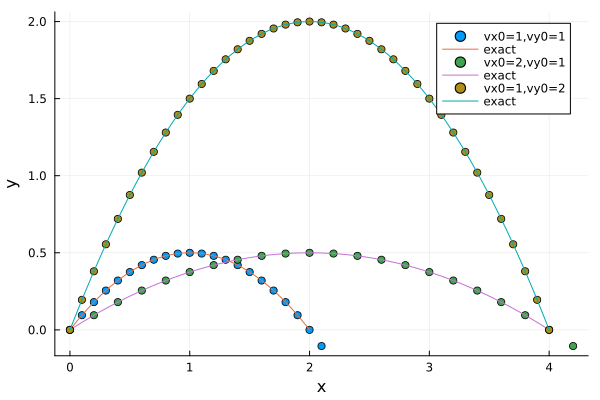

In [39]:
#my solution

tparabola1,xvparabola1=projectile_trajectory([0.,0.,1.,1.],
    projectile_dxdt(m=1,g=1,gamma=0,delta=1),0.1)
scatter([(xv[1],xv[2]) for xv in xvparabola1],label="vx0=1,vy0=1",
    xlabel="x",ylabel="y")
plot!(x->x-x^2/2,0,2,label="exact")

tparabola2,xvparabola2=projectile_trajectory([0.,0.,2.,1.],
    projectile_dxdt(m=1,g=1,gamma=0,delta=1),0.1)
scatter!([(xv[1],xv[2]) for xv in xvparabola2],label="vx0=2,vy0=1",
    xlabel="x",ylabel="y")
plot!(x->(x/2)-(x/2)^2/2,0,4,label="exact")

tparabola3,xvparabola3=projectile_trajectory([0.,0.,1.,2.],
    projectile_dxdt(m=1,g=1,gamma=0,delta=1),0.1)
scatter!([(xv[1],xv[2]) for xv in xvparabola3],label="vx0=1,vy0=2",
    xlabel="x",ylabel="y")
plot!(x->2*x-x^2/2,0,4,label="exact")

### Dropping a ball bearing in glycerol

Start with initial conditions: $(x,y,vx,vy)=(0,10,0,0)$, with parameters $m=1.g=1.,\gamma=1.,\delta=1.$.  This corresponds to the elementary problem of an object falling with viscous drag:
$$
\frac{d v_y}{dt}=-g-\frac{\gamma}{m} v_y
$$
One can integrate this to get
$$
v_y(t) = \frac{-mg}{\gamma}+ A e^{-\gamma t/m}
$$
where $A$ is a constant which is set by the initial conditions. 

Plot $v_y(t)$ and compare it with the analytic result

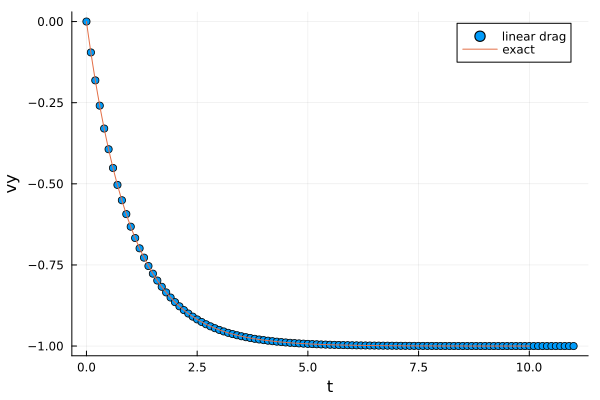

In [40]:
#my solution

tlin1,xvlin1=projectile_trajectory([0.,10.,0.,0.],
    projectile_dxdt(m=1,g=1,gamma=1,delta=1),0.1)
scatter(tlin1,[xv[4] for xv in xvlin1],label="linear drag",
    xlabel="t",ylabel="vy")
plot!(t->exp(-t)-1,0,10,label="exact")

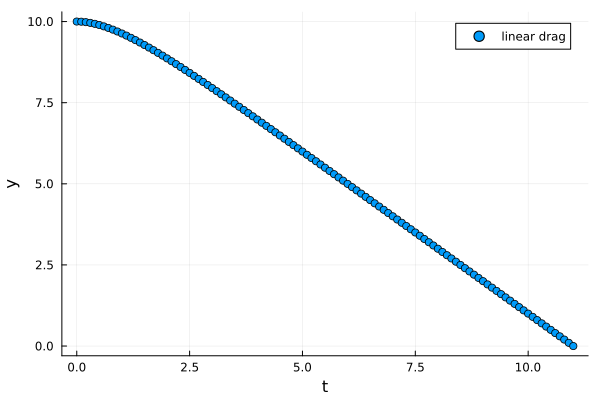

In [41]:
scatter(tlin1,[xv[2] for xv in xvlin1],label="linear drag",
    xlabel="t",ylabel="y")

### Parachuter

Now start with initial conditions: $(x,y,vx,vy)=(0.,10.,0.,0.)$, with parameters $g=1,\gamma=1,\delta=2$.  This corresponds to the elementary problem of an object falling with turbulent drag:
$$
\frac{d v_y}{dt}=-g+\frac{\gamma}{m} v_y^2,
$$
where we have assumed that $v_y<0$. 

This also can be integated, giving
$$
v_y(t)=-\sqrt{\frac{mg}{\gamma}}\tanh\left(\sqrt{\frac{\gamma g}{m}} t\right)
$$

See if your numerics gives this result

#my solution

tq1,xvq1=projectile_trajectory([0.,10.,0.,0.],
    projectile_dxdt(m=1,g=1,gamma=1,delta=2),0.1)
scatter(tlin1,[xv[4] for xv in xvq1],label="quadratic drag",
    xlabel="t",ylabel="vy")
plot!(t->-tanh(t),0,10,label="exact")

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 4
</h2>

Now that we have validated code, we can apply it to a case that we cannot solve exactly.

Lets take quadratic drag, and use units where $m=1$ and $g=1$.  We will take fixed initial conditions $v_x=v_y=1$.  Make one graph that plots trajectories with $\gamma=0,0.1,1,10$.  Label the various curves  Make sure to label your axes

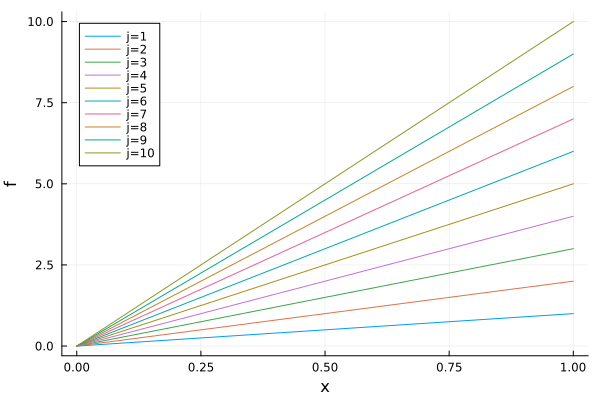

In [42]:
# You may find it useful to have plot! commands in a loop.  Here is an exmple
p1=plot(xlabel="x",ylabel="f")
for j in 1:10
    plot!(x->j*x,label="j="*string(j))
end
display(p1)

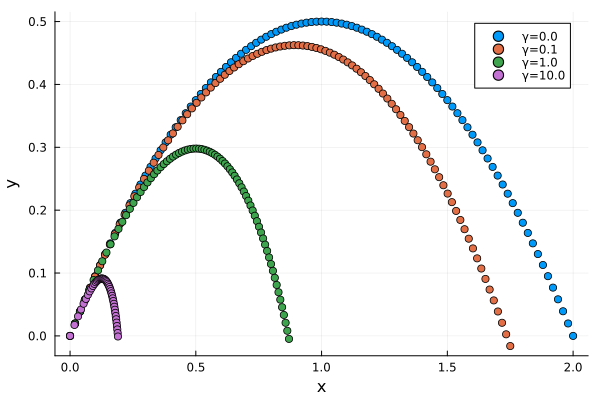

In [43]:
#my solution
gammalist=[0,0.1,1,10]
trajectorylist=[projectile_trajectory([0.,0.,1.,1.],projectile_dxdt(m=1,g=1,gamma=gamma,delta=2),0.02) 
    for gamma in gammalist]
plt=scatter([(xv[1],xv[2]) for xv in trajectorylist[1][2]],label="γ="*string(gammalist[1]),xlabel="x",ylabel="y")
res=[]
for j in 2:length(gammalist)
    res=[(xv[1],xv[2]) for xv in trajectorylist[j][2]]
    scatter!([(xv[1],xv[2]) for xv in trajectorylist[j][2]],label="γ="*string(gammalist[j]))
end
display(plt)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 5
</h2>

As a final step, we want to make a function `distance` which is called with the initial velocity `initialv=(vx,vy)` and the parameters $m,g,\gamma,\delta,dt$, and it tells us how far the projectile travels.

Our strategy is that `distance` will take the input data, and use it to call `projectile_trajectory`.  

We will then take the last two points of the trajectory, and do a linear interpolation to find the value of of $x$ at which $y=0$.  If you want, you can do a higher order interpolation (for example, using our knowledge of the velocities at those points). 

Lets first make a function which is called by those last two values: `xvp=(xp,yp,vxp,vyp)`,for "penultimate" and `xvf= (xp,yp,vxp,vyp)` for "final".  The way I like to derive my linear interpolation formulas, is that I first make a function $x(y)$ which passes through these points.  You should be able to convince yourself that
$$
x(y) = \frac{y-yp}{yf-yp} x_f +  \frac{y-yf}{yp-yf} x_p 
$$
This is obviously a linear function fo $y$ -- and if you plug in the value $y=yp$ or $y=yf$ you get the desired result.  We then just set $y=0$ to find that the projectile hits the ground at
$$
x(0)=\frac{x_f y_p-x_p y_f}{y_p-y_f}
$$
Make a function `interpx0(xvp,xvf)` which implements this formula.  Test to make sure it works.

In [44]:
#My Solution
function interpx0(xvp,xvf)
    xp,yp,vxp,vyp=xvp
    xf,yf,vxf,vyf=xvf
    return (xf*yp-xp*yf)/(yp-yf)
end

interpx0 (generic function with 1 method)

Now create the function `distance`.  Test it by comparing with a trajectory graph.  A good trick to help check for typos is to use paramters which are "generic" rather than nice.  For example start at `initialv=(3.7,1.2)` with parameters `m=7,gamma=3.2,delta=2,g=9.8`.  Of course, it they don't agree, then go back to nice numbers, which let you systematically track down the issue.

In [45]:
#You may find the following notation useful for accessing the last, and next-to-last elements of a list:
@show lst=[1,2,3,4,5]
@show lst[end]
@show lst[end-1]

lst = [1, 2, 3, 4, 5] = [1, 2, 3, 4, 5]
lst[end] = 5
lst[end - 1] = 4


4

In [46]:
#My Solution
function distance(initialv,m,g,gamma,delta,dt)
    dxdt=projectile_dxdt(m=m,gamma=gamma,delta=delta,g=g)
    times,traj=projectile_trajectory([0,0,initialv...],dxdt,dt)
    interpx0(traj[end],traj[end-1])
end

distance(;initialv,m,g,gamma,delta,dt)=distance(initialv,m,g,gamma,delta,dt)

distance (generic function with 2 methods)

In [47]:
distance(initialv=(1.,1.),m=1,g=1,gamma=1,delta=2,dt=0.1)

0.8674258113604048

**Use your distance function to create a graph of distance vs $\theta$ for a projectile launched with initial conditions $xv=(0.,0.,\cos(\theta),\sin(\theta))$, and parameters $m=1,g=1,\gamma=0,\delta=2$.  That is, the case of no drag.  You know that the maximum distance should occur at an angle of $\pi/4$.**

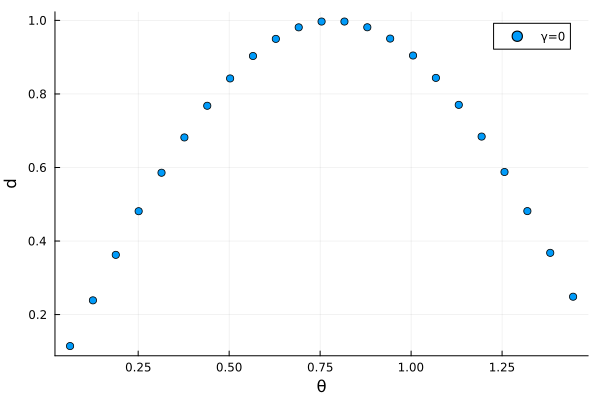

In [48]:
#My solution
thetas=collect(pi/50:pi/50:(pi/2-pi/50))
ds=[distance(initialv=(cos(theta),sin(theta)),m=1,g=1,gamma=0,delta=2,dt=0.1) for theta in thetas]
scatter(thetas,ds,xlabel="θ",ylabel="d",label="γ=0")

**Repeat, but with strong air drag: $\gamma=4$. What happens to the optimal angle?  Does adding drag make it larger or smaller than $\pi/2$?**

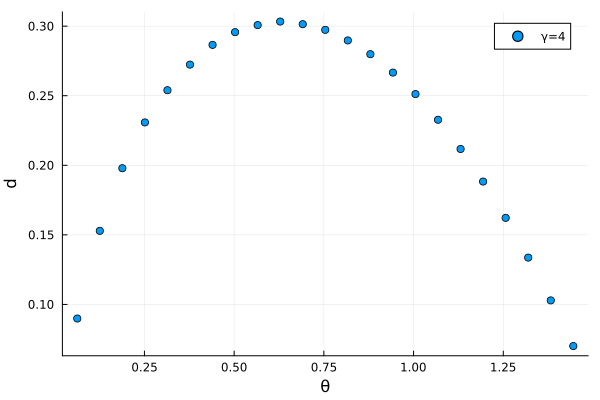

In [49]:
#My solution
thetas=collect(pi/50:pi/50:(pi/2-pi/50))
ds_drag=[distance(initialv=(cos(theta),sin(theta)),m=1,g=1,gamma=4,delta=2,dt=0.1) for theta in thetas]
scatter(thetas,ds_drag,xlabel="θ",ylabel="d",label="γ=4")

The optimal angle becomes smaller.